# 2024 COMP90042 Project - Tues9AM_Group6
*Make sure you change the file name with your group id.*

# Readme
This model is the transformer model for label classification. It has code to take predicted inputs from the transformer model for evidence retrieval and predictions from my team member Noah's predictions. The input can only be read after the transformer evidence retrieval is provided or Noah's model predictions.

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [1]:
## import libraries

#!pip3 install torchtext==0.4.0

# Standard libraries
import math
import string
import pandas as pd
import numpy as np
import json
import time
import ast

# Machine learning and deep learning libraries
import tensorflow as tf
import keras
from keras import layers
from keras import ops
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.data import Field, LabelField, Example, Dataset

# Natural Language Processing (NLP) libraries
import nltk

# Visualization
import matplotlib.pyplot as plt



In [2]:
## reading in json files

"""
Description of json files
* [train-claims,dev-claims].json: JSON files for the labelled training and development set; 
* evidence.json: JSON file containing a large number of evidence passages (i.e. the “knowledge source”); 
* dev-claims-baseline.json: JSON file containing predictions of a baseline system on the development set;
"""

## relative file paths

## baseline system - will not be used for any training/evaluation
devClaimsBaselineFile='./data/dev-claims-baseline.json'
## use this for model training
trainClaimsFile='./data/train-claims.json'
## use this set for hyperparameter tuning and evaluation metric 
devClaimsFile='./data/dev-claims.json'
## evidence files need to be downloaded through https://drive.google.com/file/d/1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6/view?usp=sharing as it is to big to be uploaded to github
evidenceFile='./data/evidence.json'

# these are files taken after the transformer has ouputted evidence id predictions

testFile='./data/test-claims-unlabelled.json'

resultsFile='./data/resultingData.json'

tokenizer=get_tokenizer("basic_english")

# Load the JSON data
with open(trainClaimsFile, 'r') as file:
    trainClaims=json.load(file)
with open(devClaimsFile, 'r') as file:
    devClaims=json.load(file)
with open(evidenceFile, 'r') as file:
    evidenceData=json.load(file)
with open(resultsFile, 'r') as file:
    resultsData=json.load(file)

## Preprocessing data -- lowercase, tokenize, and stopword removal
stopwords=set(nltk.corpus.stopwords.words('english'))
tokenizer=get_tokenizer('basic_english')
punctuations=string.punctuation

def preprocess(text):
    token=tokenizer(text.lower())
    cleanedTokens=[t for t in token if (t not in stopwords) and (t not in punctuations)]
    return ' '.join(cleanedTokens)

for ids, texts in evidenceData.items():
    evidenceData[ids]=preprocess(texts)

# Function to create DataFrame and merge evidence IDs with Text
def createDF(claims, evidence):
    combinedData=[]
    for claimID, claimText in claims.items():
        # Combine the ID with its corresponding evidences
        evidenceID=claimText['evidences']
        evidenceText=(evidence[i] for i in evidenceID if i in evidence)
        combinedData.append({
            'claim_id': claimID,
            'claim_text': preprocess(claimText['claim_text']),
            'evidence_id': evidenceID,
            'evidence_text': " ".join(evidenceText),
            'claim_label': claimText['claim_label']
        })
    # Create DataFrame
    return pd.DataFrame(combinedData)

def createDFResults(claimsJson):
    combinedData = []
    for claimID, claimDetails in claimsJson.items():
        claimText = preprocess(claimDetails['claim_text'][0]) 
        evidenceIDs = claimDetails['evidences']
        evidenceTexts = claimDetails['evidence_text']
        processed_texts = [preprocess(text) for text in evidenceTexts] 
        combinedData.append({
            'claim_id': claimID,
            'claim_text': claimText,
            'evidence_ids': evidenceIDs,
            'evidence_text': processed_texts
        })
        
    return pd.DataFrame(combinedData)

resultsMerged=createDFResults(resultsData)
resultsMerged.to_csv('./data/processedResults.csv',index=False)

# Create CSV Files
trainFullMerged=createDF(trainClaims,evidenceData)
devFullMerged=createDF(devClaims,evidenceData)
trainFullMerged.to_csv("data/trainFullMerged.csv", index=False)
devFullMerged.to_csv("data/devFullMerged.csv", index=False)

# Convert evidence into csv as well
evidenceFinal=pd.DataFrame(list(evidenceData.items()),columns=['evidence_id','evidence_text'])
evidenceFinal.to_csv('data/evidencePreprocessed.csv',index=False)

# Convert unlabelled Data into CSV as well
with open(testFile, 'r') as file:
    testData=json.load(file)
for ids, texts in testData.items():
    claim_text = texts['claim_text']
    testData[ids]=preprocess(claim_text)
testFinal=pd.DataFrame(list(testData.items()), columns=['claim_id', 'claim_text'])
testFinal.to_csv('data/testPreprocessed.csv',index=False)

In [3]:
## use this for model training
trainClaimsFile='./data/trainFullMerged.csv'
## use this set for hyperparameter tuning and evaluation metric 
devClaimsFile='./data/devFullMerged.csv'
## evidence files need to be downloaded through googledrive (https://drive.google.com/file/d/1OyihwdAWfqHIOueCB4bLBkYg4hTN_OKm/view?usp=sharing)
evidenceFile='./data/evidencePreprocessed.csv'
## test unlabelled dataset
testFile='./data/testPreprocessed.csv'
##results file
resultsFile='./data/processedResults.csv'


trainDataframe=pd.read_csv(trainClaimsFile)
devDataframe=pd.read_csv(devClaimsFile)
evidenceDataframe=pd.read_csv(evidenceFile)
testDataframe=pd.read_csv(testFile)
resultsDataframe=pd.read_csv(resultsFile)

trainDataframe['claim_text']=trainDataframe['claim_text']
trainDataframe['combined_evidence']=trainDataframe['evidence_id']+" "+trainDataframe['evidence_text']
trainDataframe['combined_input'] = trainDataframe['claim_text'] + " [SEP] " + trainDataframe['evidence_text']

devDataframe['claim_text']=devDataframe['claim_text']
devDataframe['combined_evidence']=devDataframe['evidence_id'] +" "+ devDataframe['evidence_text']
devDataframe['combined_input'] = devDataframe['claim_text'] + " [SEP] " + devDataframe['evidence_text']

resultsDataframe['combined_input']=resultsDataframe['claim_text'] + " [SEP] "+ resultsDataframe['evidence_text']

In [4]:
## Preprocessing data -- lowercase, tokenize, and stopword removal
stopwords=set(nltk.corpus.stopwords.words('english'))
tokenizer=get_tokenizer('basic_english')
punctuations=set(string.punctuation)

def preprocess(text):
    tokens=tokenizer(text)
    cleanedTokens = [token for token in tokens if token not in stopwords and token not in punctuations]
    return cleanedTokens

TEXT = Field(lower=True, init_token='<sos>', eos_token='<eos>', batch_first=True)
LABEL=LabelField(sequential=False)

def createDatasetEncoderInput(dataframe,textTransform,labelTransform):
    field=[('reviewTextInput',textTransform),('evidenceTextOutput',labelTransform)]
    examples=[]
    for _, row in dataframe.iterrows():
        reviewTextInput=row['combined_input']
        evidenceTextOutput=row['claim_label']
        examples.append(Example.fromlist([reviewTextInput,evidenceTextOutput], field))
    return Dataset(examples,fields=field)

def createDatasetOutput(dataframe,labelTransform):
    field=[('evidenceTextOutput',labelTransform)]
    examples=[]
    for _, row in dataframe.iterrows():
        evidenceTextOutput=row['claim_label']
        examples.append(Example.fromlist([evidenceTextOutput], field))
    return Dataset(examples,fields=field)

def createDatasetTest(dataframe,textTransform):
    field=[('reviewTextInput',textTransform)]
    examples=[]
    for _, row in dataframe.iterrows():
        reviewTextInput=row['combined_input']
        examples.append(Example.fromlist([reviewTextInput], field))
    return Dataset(examples,fields=field)

trainTensor = createDatasetEncoderInput(trainDataframe, TEXT,LABEL)
devTensor = createDatasetEncoderInput(devDataframe, TEXT,LABEL)
#evidenceTensor=createDatasetOutput(evidenceDataframe,LABEL)
#testTensor=createDatasetTest(testDataframe,TEXT)
resultsTensor=createDatasetTest(resultsDataframe,TEXT)


In [5]:
#build a text vocabulary for the text using the training data, along with a label vocab for the ouputs to be mapped back to labels

TEXT.build_vocab(trainTensor)
LABEL.build_vocab(trainTensor)

vocabSize=len(TEXT.vocab.stoi)

In [6]:
# sets up device to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# converts the data into tensors
def tensorConversion(dataset):
    data = TEXT.process([getattr(x, 'reviewTextInput') for x in dataset.examples])
    label = LABEL.process([getattr(x, 'evidenceTextOutput') for x in dataset.examples])
    return data.to(device), label.to(device)

## test is used for the final predictions
TEST = Field(tokenize=preprocess, lower=True, init_token='<sos>', eos_token='<eos>', batch_first=True)
TEST.build_vocab(trainTensor)
def processTextOnly(dataset):
    data = TEST.process([getattr(x, 'reviewTextInput') for x in dataset.examples])
    return data.to(device)

        
train_data,train_label = tensorConversion(trainTensor)
dev_data,dev_label = tensorConversion(devTensor)
dev_accuracy_data=processTextOnly(devTensor)
results_accuracy_data=processTextOnly(resultsTensor)
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [8]:
#converts the data into numpy format
train_numpy_data=train_data.numpy()
train_numpy_label=train_label.numpy()
dev_numpy_data=dev_data.numpy()
dev_numpy_label=dev_label.numpy()
results_numpy_data=results_accuracy_data.numpy()

In [9]:
## THIS SECTION IS ONLY USED TO CLASSIFY NOAH'S PREDICTIONS ##

# def createDFResultsNoah(claimsJson):
#     combinedData = []
#     for claimID, claimDetails in claimsJson.items():
#         evidenceIDs = claimDetails['evidences']
#         combinedData.append({
#             'claim_id': claimID,
#             'claim_text': preprocess(claimDetails['claim_text']),
#             'evidence_ids': evidenceIDs,
#         })
        
#     return pd.DataFrame(combinedData)

# #reading in Noah's predictions
# noahEvidence='./data/pred_dev_claims.json'

# with open(noahEvidence,'r') as file:
#     noahData=json.load(file)

# noahDataframe=createDFResultsNoah(noahData)
# # print(noahMerged)
# # print(evidenceDataframe)

# evidenceDict = pd.Series(evidenceDataframe['evidence_text'].values, index=evidenceDataframe['evidence_id']).to_dict()

# def getEvidenceTexts(evidence_ids):
#     texts=[str(evidenceDict.get(eid, "")) for eid in evidence_ids if eid in evidenceDict]
#     return " ".join(texts)
# noahDataframe['evidence_text']=noahDataframe['evidence_ids'].apply(getEvidenceTexts)
# noahDataframe['combined_input']=noahDataframe['claim_text'].apply(lambda x: ' '.join(x)) + " [SEP] "+ noahDataframe['evidence_text']
# noahTensor=createDatasetTest(noahDataframe,TEXT)
# noahAccuracyData=processTextOnly(noahTensor)
# noahNumpy=noahAccuracyData.numpy()

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [10]:
# encoder only transformer to predict classification labels
# code was inspired from https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [11]:
#initialize the model

embed_dim = 64  # emb size
num_heads = 8  # attention head
ff_dim = 64  # layer size

inputs = layers.Input(shape=(None,))
embedding_layer = TokenAndPositionEmbedding(400, vocabSize, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
## evaluate the accuracy and loss during model training

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

total_start_time = time.time()

history = model.fit(
    train_numpy_data, 
    train_numpy_label, 
    batch_size=32, 
    epochs=15, 
    validation_data=(dev_numpy_data, dev_numpy_label)
)


Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 558ms/step - accuracy: 0.6105 - loss: 0.9320 - val_accuracy: 0.5779 - val_loss: 1.0636
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 536ms/step - accuracy: 0.6967 - loss: 0.7392 - val_accuracy: 0.5390 - val_loss: 1.2063
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 584ms/step - accuracy: 0.7809 - loss: 0.5577 - val_accuracy: 0.4935 - val_loss: 1.6420
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 574ms/step - accuracy: 0.8393 - loss: 0.3941 - val_accuracy: 0.5260 - val_loss: 1.6696
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 566ms/step - accuracy: 0.8978 - loss: 0.2374 - val_accuracy: 0.5000 - val_loss: 1.6732
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 558ms/step - accuracy: 0.9514 - loss: 0.1627 - val_accuracy: 0.5844 - val_loss: 1.5809
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.9803 - loss: 0.0866 - val_accuracy: 0.5714 - val_loss: 2.0512
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 568ms/step - accuracy: 0.9905 - loss: 0.0544 - val_accu

Total training time: 331.30 seconds


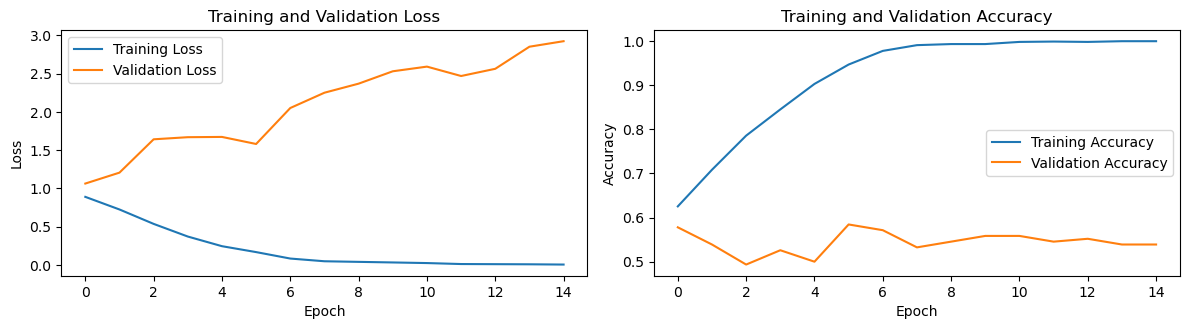

In [14]:
## visualize the model accuracy and losses

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f'Total training time: {total_training_time:.2f} seconds')

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
#used to save models

#model.save('./runs/classificationAccuracyUsed.keras')
#model=keras.models.load_model('./runs/classificationAccuracyUsed.keras')

In [16]:
## change this line to the numpy data you want to predict - default to development set
pred=model.predict(dev_numpy_data)

class_predictions = np.argmax(pred, axis=1)

print(class_predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
[2 1 0 1 0 1 1 0 1 0 2 2 0 2 1 1 0 0 2 1 0 0 1 2 1 0 2 0 1 1 0 0 0 1 2 1 0
 2 2 0 0 1 0 1 1 1 2 0 0 3 1 0 0 0 0 1 1 1 1 3 1 0 2 1 0 1 0 1 0 1 0 0 2 2
 1 1 0 1 1 0 0 0 0 0 3 0 1 3 1 1 0 1 1 1 2 2 1 1 2 0 1 2 2 1 1 2 2 0 3 0 0
 1 1 0 1 2 1 1 2 1 0 3 0 2 0 2 2 2 1 0 1 3 1 1 0 1 0 0 2 3 2 0 0 2 2 0 1 2
 0 1 1 0 3 0]


In [17]:
#maps prediction back to classification labels
label_names = [LABEL.vocab.itos[i] for i in class_predictions]
print(label_names)

['REFUTES', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'REFUTES', 'REFUTES', 'SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'REFUTES', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'REFUTES', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'REFUTES', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'REFUTES', 'REFUTES', 'SUPPORTS', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO', 'REFUTES', 'SUPPORTS', 'SUPPORTS', 'DISPUTED', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO', 'DISPUTED', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'SUPPORTS', 'NOT_ENOUGH_INFO', 'SUPPO

In [18]:
#prepare data 
resultsDataframe['claim_label']=label_names
finalDataframe=resultsDataframe.rename(columns={
    'evidence_ids':'evidences'
})

In [19]:
## FOR NOAHS DATA ##
# noahDataframe['claim_label']=label_names

# finalDataframe=noahDataframe.rename(columns={
#     'evidence_ids':'evidences'
# })

In [20]:
## FOR NOAHS DATA ##

# import ast

# claims_dict = {}
# for index, row in finalDataframe.iterrows():
#     if isinstance(row['evidences'], list):
#         evidences_list = row['evidences']
#     else:
#         evidences_list = ast.literal_eval(row['evidences'])   
#     claims_dict[row['claim_id']] = {
#         'evidences': evidences_list,
#         'claim_label': row['claim_label']
#     }

# # Saving the dictionary to a JSON file
# with open('./data/full_transformer_categorical.json', 'w') as json_file:
#     json.dump(claims_dict, json_file, indent=4)

In [21]:
## change data labels to be ready for predictions and eval.py

claims_dict = {}
for index, row in finalDataframe.iterrows():
    evidences_list = ast.literal_eval(row['evidences'])
    claims_dict[row['claim_id']] = {
        'claim_text': [row['claim_text']],
        'evidences': evidences_list,
        'claim_label': row['claim_label']
    }

# Saving the dictionary to a JSON file
# with open('./data/final_predictions_all_transformer.json', 'w') as json_file:
#     json.dump(claims_dict, json_file, indent=4)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*